# Testing - scent grid w/ patches of missing values - 1

Grad versus Info

In [2]:
import shutil
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import explorationlib
from explorationlib.local_gym import ScentGrid

from explorationlib.agent import DiffusionGrid
from explorationlib.agent import AccumulatorGradientGrid
from explorationlib.agent import AccumulatorInfoGrid

from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import constant_values
from explorationlib.local_gym import ScentGrid
from explorationlib.local_gym import create_grid_scent
from explorationlib.local_gym import create_grid_scent_patches

from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import plot_scent_grid

from explorationlib.score import total_reward
from explorationlib.score import num_death

pygame 2.0.1 (SDL 2.0.14, Python 3.6.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True

plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Uncomment for local development
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

# Shared params, env, and agents

In [16]:
num_steps = 100
cog_mult = 5

min_length = 1
step_size = 1
noise_sigma = 2
detection_radius = 1

seed_value = 42

# Targets
num_targets = 10 # 5000-50000
target_boundary = (10, 10)

prng = np.random.RandomState(seed_value)
targets = uniform_targets(num_targets, target_boundary, prng=prng)
values = constant_values(targets, 1)

# Scents
scents = []
for _ in range(len(targets)):
    coord, scent = create_grid_scent_patches(
        target_boundary, p=0.1, amplitude=1, sigma=2)
    scents.append(scent)

# Env
env = ScentGrid(mode=None)
env.seed(seed_value)
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

<IPython.core.display.Javascript object>

### Vis "patchy" scent

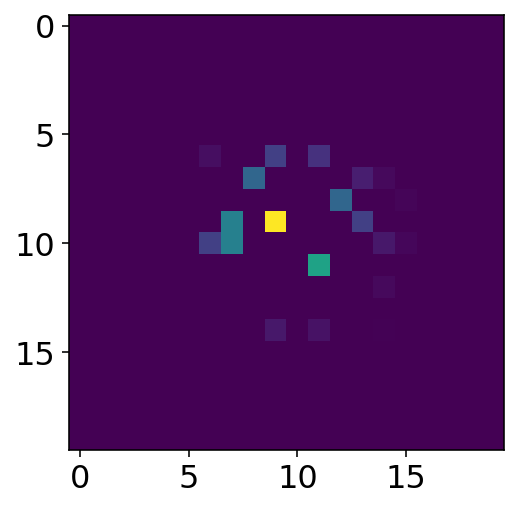

<IPython.core.display.Javascript object>

In [14]:
plt.imshow(scent, interpolation=None)

# p_neg=1, p_pos=0.0

There are the best setting for no noise

In [17]:
# Experiment settings
num_experiments = 250
max_steps = 1

# Agents
diff = DiffusionGrid(min_length=min_length, scale=1)
diff.seed(seed_value)

chemo = AccumulatorGradientGrid(
    min_length=min_length, 
    max_steps=max_steps, 
    drift_rate=1, 
    threshold=3,
    accumulate_sigma=1
)
chemo.seed(seed_value)

info = AccumulatorInfoGrid(
    min_length=min_length, 
    max_steps=max_steps, 
    drift_rate=1, 
    threshold=3,
    accumulate_sigma=1
)
info.seed(seed_value)

# !
rand_exp = experiment(
    f"rand",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
chemo_exp = experiment(
    f"chemo",
    chemo,
    env,
    num_steps=num_steps * cog_mult,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
info_exp = experiment(
    f"info",
    info,
    env,
    num_steps=num_steps * cog_mult,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)

info: 100%|██████████| 250/250 [01:12<00:00,  3.45it/s]


<IPython.core.display.Javascript object>

## Example 

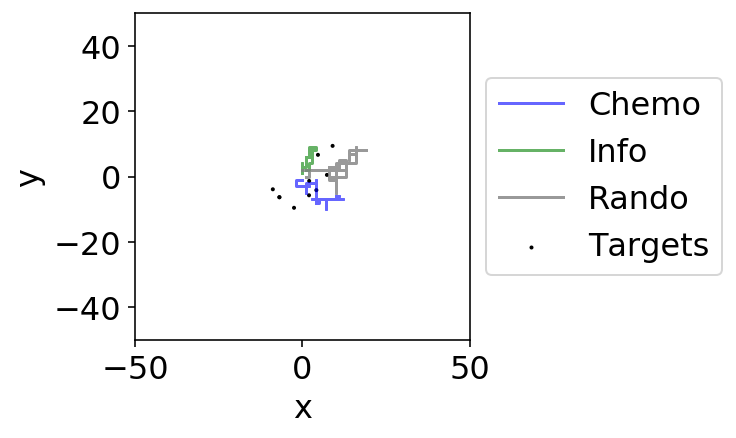

<IPython.core.display.Javascript object>

In [26]:
plot_boundary = (50, 50)

num_experiment = 99
ax = None
ax = plot_position2d(
    select_exp(chemo_exp, num_experiment),
    boundary=plot_boundary,
    label="Chemo",
    color="blue",
    alpha=0.6,
    ax=ax,
)
ax = plot_position2d(
    select_exp(info_exp, num_experiment),
    boundary=plot_boundary,
    label="Info",
    color="green",
    alpha=0.6,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)
ax = plot_position2d(
    select_exp(rand_exp, num_experiment),
    boundary=plot_boundary,
    label="Rando",
    color="grey",
    alpha=0.8,
    ax=ax,
)

## Total distance

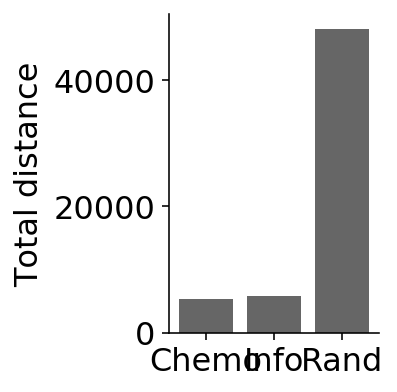

<IPython.core.display.Javascript object>

In [19]:
# Results
results = [chemo_exp, info_exp, rand_exp]
names = ["Chemo", "Info", "Rando"]
colors = ["blue", "green", "grey"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    l = 0.0
    for r in res:
        l += r["agent_total_l"][-1]
    scores.append(l)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Total distance")
plt.tight_layout()
sns.despine()

## Deaths

num_death: 100%|██████████| 250/250 [00:00<00:00, 18588.48it/s]


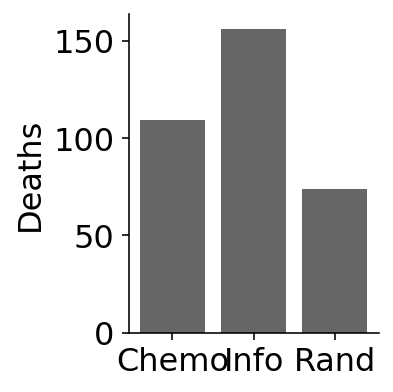

<IPython.core.display.Javascript object>

In [20]:
# Results
results = [chemo_exp, info_exp, rand_exp]
names = ["Chemo", "Info", "Rando"]
colors = ["blue", "green", "grey"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    scores.append(num_death(res))   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.tight_layout()
sns.despine()

## Avg reward

total_reward: 100%|██████████| 250/250 [00:00<00:00, 41233.82it/s]


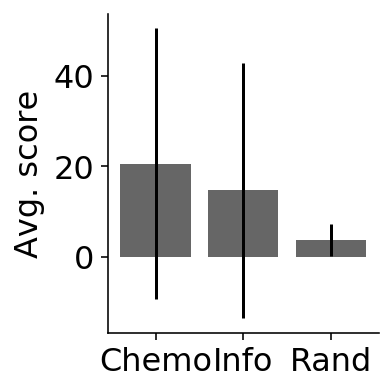

<IPython.core.display.Javascript object>

In [21]:
# Results
results = [chemo_exp, info_exp, rand_exp]
names = ["Chemo", "Info", "Rando"]
colors = ["blue", "green", "grey"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Avg. score")
plt.tight_layout()
sns.despine()

## Best exp

total_reward: 100%|██████████| 250/250 [00:00<00:00, 19377.17it/s]


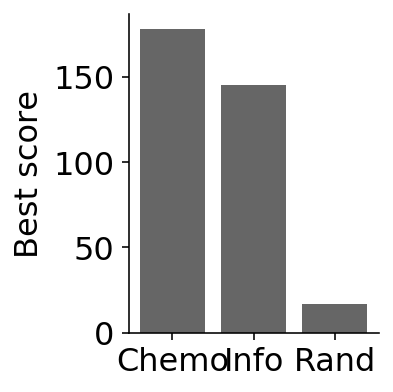

<IPython.core.display.Javascript object>

In [22]:
# Results
results = [chemo_exp, info_exp, rand_exp]
names = ["Chemo", "Info", "Rand"]
colors = ["blue", "green", "grey"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.max(s))

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar(names, m, color="black", alpha=0.6)
plt.ylabel("Best score")
plt.tight_layout()
sns.despine()

## Reward histogram

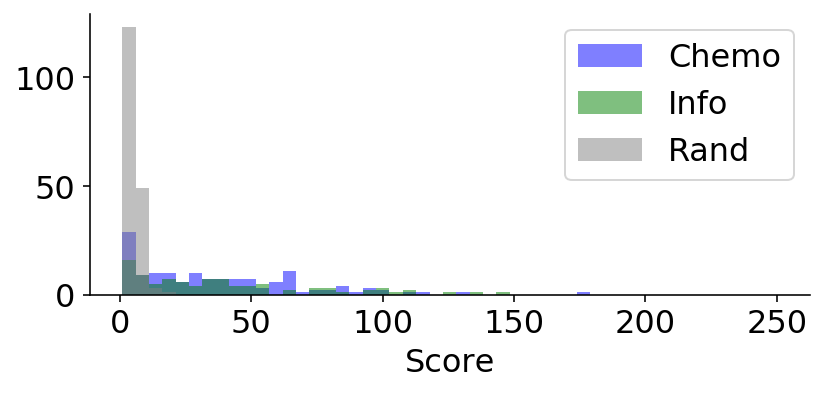

<IPython.core.display.Javascript object>

In [25]:
# Dists
fig = plt.figure(figsize=(6, 3))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, 
        bins=np.linspace(1, 250, 50))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()